In [1]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import rankdata, genpareto
from statsmodels.nonparametric.kde import KDEUnivariate
from statsmodels.stats.diagnostic import acorr_ljungbox
import seaborn as sns

In [2]:
df = pd.read_excel("USA_Brent.xlsx")

In [3]:
print(df.dtypes)

Date           datetime64[ns]
Close_sp              float64
Brent_Crude           float64
dtype: object


In [4]:
df

,Date,Close_sp,Brent_Crude
0,2015-01-02,2058.199951,55.38
1,2015-01-05,2020.579956,51.08
2,2015-01-06,2002.609985,50.12
3,2015-01-07,2025.900024,49.06
4,2015-01-08,2062.139893,49.43
...,...,...,...
2372,2024-03-22,5234.180176,84.87
2373,2024-03-25,5218.189941,86.18
2374,2024-03-26,5203.580078,85.91
2375,2024-03-27,5248.490234,84.94


In [5]:
missing_values = df.isnull().sum()
print(missing_values)

Date            0
Close_sp       53
Brent_Crude    30
dtype: int64


In [6]:
#Define the date ranges
pre_covid_start = '2015-01-01'
pre_covid_end = '2020-02-29'
covid_start = '2020-03-01'
covid_end = '2022-02-28'
post_covid_start = '2022-03-01'
post_covid_end = '2024-03-31'

In [7]:
# Filter the data
pre_covid_data = df[(df['Date'] >= pre_covid_start) & (df['Date'] <= pre_covid_end)]
covid_data = df[(df['Date'] >= covid_start) & (df['Date'] <= covid_end)]
post_covid_data = df[(df['Date'] >= post_covid_start) & (df['Date'] <= post_covid_end)]

In [8]:
pre_covid_data.tail()

,Date,Close_sp,Brent_Crude
1321,2020-02-24,3225.889893,56.71
1322,2020-02-25,3128.209961,55.29
1323,2020-02-26,3116.389893,54.96
1324,2020-02-27,2978.760010,52.19
1325,2020-02-28,2954.219971,51.31


In [9]:
missing_values = pre_covid_data.isnull().sum()
print(missing_values)

Date            0
Close_sp       28
Brent_Crude     9
dtype: int64


In [10]:
# Forward fill missing values
pre_covid_data.fillna(method='ffill', inplace=True)

C:\Users\KASHISH NIGAM\AppData\Local\Temp\ipykernel_26772\1485561790.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pre_covid_data.fillna(method='ffill', inplace=True)


#### ADF TEST

In [11]:
time_series_columns = ['Close_sp', 'Brent_Crude']

def adf_test(timeseries):
    result = adfuller(timeseries, autolag='AIC')
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'   {key}: {value}')

# Loop over each column and perform ADF test
for column in time_series_columns:
    print(f"ADF Test Results for {column}:")
    adf_test(pre_covid_data[column])
    print()

ADF Test Results for Close_sp:
ADF Statistic: -1.0640842418041567
p-value: 0.7291801953946213
Critical Values:
   1%: -3.4353061595148073
   5%: -2.863728748588099
   10%: -2.567935298646666

ADF Test Results for Brent_Crude:
ADF Statistic: -1.8946607438421583
p-value: 0.3345770192415882
Critical Values:
   1%: -3.435294916169133
   5%: -2.863723787379918
   10%: -2.5679326566037735



In [12]:
# Here are the detailed interpretations of the ADF test results for both `Close_sp` and `Brent_Crude`:

# ### ADF Test Results for Close_sp:
# - **ADF Statistic**: -1.0640842418041567
# - **p-value**: 0.7291801953946213
# - **Critical Values**:
#   - 1%: -3.4353061595148073
#   - 5%: -2.863728748588099
#   - 10%: -2.567935298646666

# ### Interpretation for Close_sp:
# - The ADF statistic (-1.064) is higher (less negative) than the critical values at 1%, 5%, and 10% significance levels.
# - The p-value (0.729) is greater than 0.05.
# - **Conclusion**: We fail to reject the null hypothesis. This means that `Close_sp` is non-stationary.

# ### ADF Test Results for Brent_Crude:
# - **ADF Statistic**: -1.8946607438421583
# - **p-value**: 0.3345770192415882
# - **Critical Values**:
#   - 1%: -3.435294916169133
#   - 5%: -2.863723787379918
#   - 10%: -2.5679326566037735

# ### Interpretation for Brent_Crude:
# - The ADF statistic (-1.894) is higher (less negative) than the critical values at 1%, 5%, and 10% significance levels.
# - The p-value (0.335) is greater than 0.05.
# - **Conclusion**: We fail to reject the null hypothesis. This means that `Brent_Crude` is non-stationary.

# ### Summary:
# Both `Close_sp` and `Brent_Crude` series are non-stationary based on the ADF test results. In both cases, the ADF statistics are higher than the critical values, and the p-values are greater than 0.05, leading us to fail to reject the null hypothesis of the presence of a unit root in both series.

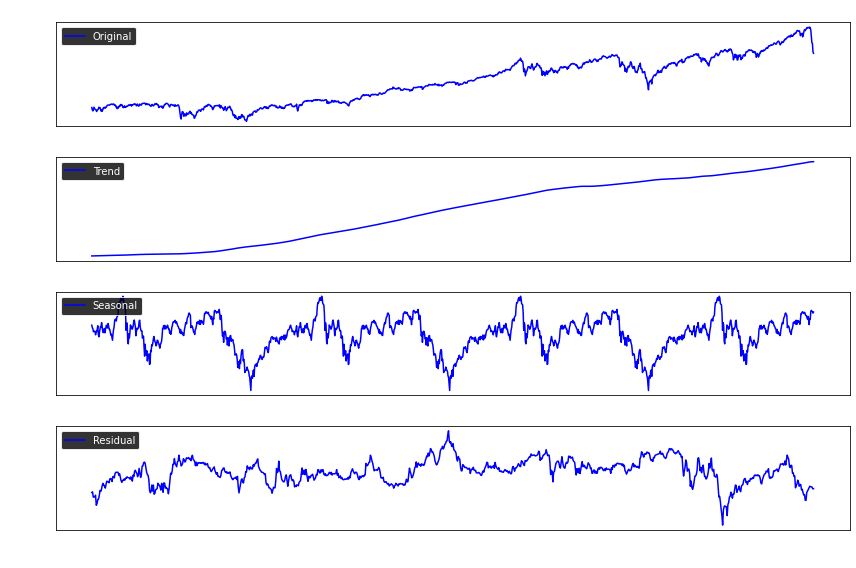

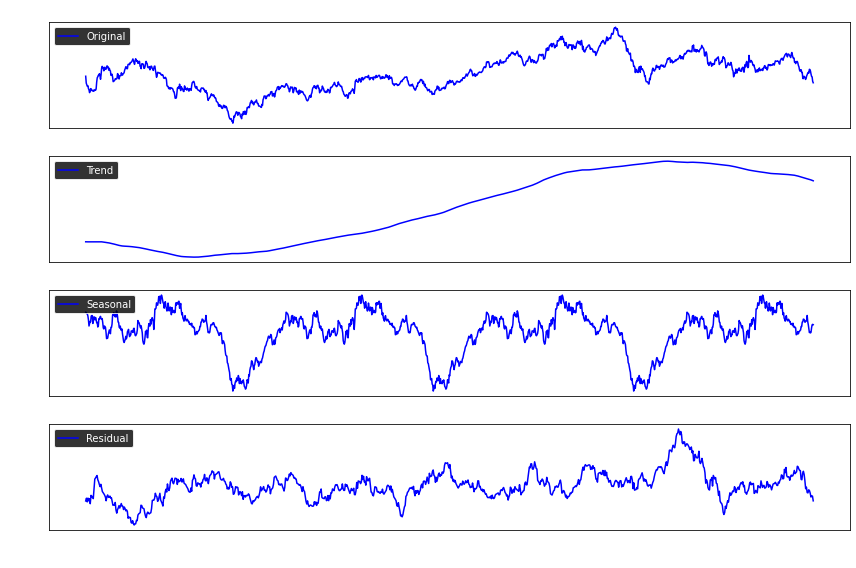

In [13]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# Decompose the time series
result = seasonal_decompose(pre_covid_data['Close_sp'], model='additive', period=365)

# Plot the decomposed components
plt.figure(figsize=(12, 8))

plt.subplot(411)
plt.plot(pre_covid_data['Close_sp'], label='Original', color='blue')
plt.legend(loc='upper left', facecolor='black', edgecolor='white', labelcolor='white')
plt.ylabel('Original', color='white')
plt.tick_params(axis='x', colors='white')
plt.tick_params(axis='y', colors='white')
plt.title('Time Series Decomposition', color='white')

plt.subplot(412)
plt.plot(result.trend, label='Trend', color='blue')
plt.legend(loc='upper left', facecolor='black', edgecolor='white', labelcolor='white')
plt.ylabel('Trend', color='white')
plt.tick_params(axis='x', colors='white')
plt.tick_params(axis='y', colors='white')

plt.subplot(413)
plt.plot(result.seasonal, label='Seasonal', color='blue')
plt.legend(loc='upper left', facecolor='black', edgecolor='white', labelcolor='white')
plt.ylabel('Seasonal', color='white')
plt.tick_params(axis='x', colors='white')
plt.tick_params(axis='y', colors='white')

plt.subplot(414)
plt.plot(result.resid, label='Residual', color='blue')
plt.legend(loc='upper left', facecolor='black', edgecolor='white', labelcolor='white')
plt.ylabel('Residual', color='white')
plt.tick_params(axis='x', colors='white')
plt.tick_params(axis='y', colors='white')
plt.xlabel('Date', color='white')

plt.tight_layout()
plt.show()


import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose the time series
result = seasonal_decompose(pre_covid_data['Brent_Crude'], model='additive', period=365)

# Plot the decomposed components
plt.figure(figsize=(12, 8))

plt.subplot(411)
plt.plot(pre_covid_data['Brent_Crude'], label='Original', color='blue')
plt.legend(loc='upper left', facecolor='black', edgecolor='white', labelcolor='white')
plt.ylabel('Original', color='white')
plt.tick_params(axis='x', colors='white')
plt.tick_params(axis='y', colors='white')
plt.title('Time Series Decomposition', color='white')

plt.subplot(412)
plt.plot(result.trend, label='Trend', color='blue')
plt.legend(loc='upper left', facecolor='black', edgecolor='white', labelcolor='white')
plt.ylabel('Trend', color='white')
plt.tick_params(axis='x', colors='white')
plt.tick_params(axis='y', colors='white')

plt.subplot(413)
plt.plot(result.seasonal, label='Seasonal', color='blue')
plt.legend(loc='upper left', facecolor='black', edgecolor='white', labelcolor='white')
plt.ylabel('Seasonal', color='white')
plt.tick_params(axis='x', colors='white')
plt.tick_params(axis='y', colors='white')

plt.subplot(414)
plt.plot(result.resid, label='Residual', color='blue')
plt.legend(loc='upper left', facecolor='black', edgecolor='white', labelcolor='white')
plt.ylabel('Residual', color='white')
plt.tick_params(axis='x', colors='white')
plt.tick_params(axis='y', colors='white')
plt.xlabel('Date', color='white')

plt.tight_layout()
plt.show()

In [14]:
summary = pre_covid_data.describe()
print(summary)

          Close_sp  Brent_Crude
count  1326.000000  1326.000000
mean   2479.689878    57.225256
std     380.647228    11.419492
min    1829.079956    26.010000
25%    2104.254944    48.430000
50%    2455.525024    57.370000
75%    2792.164917    64.920000
max    3386.149902    86.070000


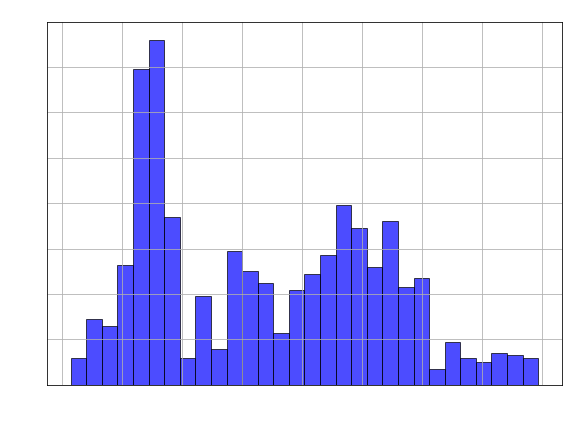

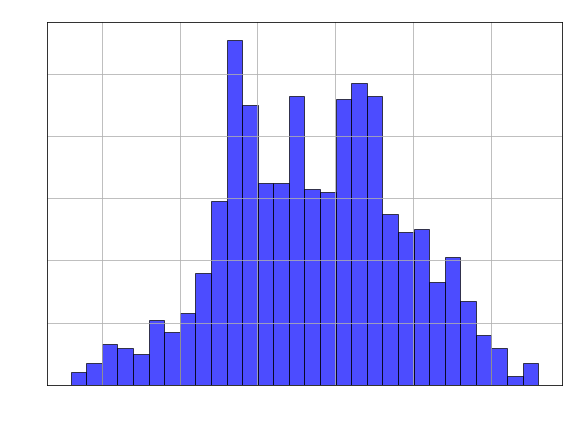

In [15]:
import matplotlib.pyplot as plt

# Plot histogram for 'Close_sp'
plt.figure(figsize=(8, 6))
plt.hist(pre_covid_data['Close_sp'], bins=30, color='blue', edgecolor='black', alpha=0.7)

# Add labels and title
plt.xlabel('Close_sp', color='white')
plt.ylabel('Frequency', color='white')
plt.title('Histogram of Close_sp', color='white')

# Customize tick parameters to be white
plt.tick_params(axis='x', colors='white')
plt.tick_params(axis='y', colors='white')

# Show grid and plot
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot histogram for 'Brent_Crude'
plt.figure(figsize=(8, 6))
plt.hist(pre_covid_data['Brent_Crude'], bins=30, color='blue', edgecolor='black', alpha=0.7)

# Add labels and title
plt.xlabel('Brent_Crude', color='white')
plt.ylabel('Frequency', color='white')
plt.title('Histogram of Brent_Crude', color='white')

# Customize tick parameters to be white
plt.tick_params(axis='x', colors='white')
plt.tick_params(axis='y', colors='white')

# Show grid and plot
plt.grid(True)
plt.tight_layout()
plt.show()

In [16]:
pre_covid_data = pre_covid_data.copy()
pre_covid_data['Log_Return_Close_sp'] = np.log(pre_covid_data['Close_sp'] / pre_covid_data['Close_sp'].shift(1))
pre_covid_data['Log_Return_Brent_Crude'] = np.log(pre_covid_data['Brent_Crude'] / pre_covid_data['Brent_Crude'].shift(1))

In [17]:
missing_values = pre_covid_data.isnull().sum()
print(missing_values)

Date                      0
Close_sp                  0
Brent_Crude               0
Log_Return_Close_sp       1
Log_Return_Brent_Crude    1
dtype: int64


In [18]:
pre_covid_data = pre_covid_data.dropna()

In [19]:
missing_values = pre_covid_data.isnull().sum()
print(missing_values)

Date                      0
Close_sp                  0
Brent_Crude               0
Log_Return_Close_sp       0
Log_Return_Brent_Crude    0
dtype: int64


In [20]:
import pandas as pd
from scipy.stats import skew, kurtosis, jarque_bera
# Create a summary statistics DataFrame for pre_covid_data
summary_stats_pre_covid = pd.DataFrame(index=pre_covid_data.columns, columns=['Mean', 'Max', 'Min', 'SD', 'Skew', 'Ex. Kurt.', 'J–B'])

for col in pre_covid_data.columns:
    if pd.api.types.is_numeric_dtype(pre_covid_data[col]):
        summary_stats_pre_covid.at[col, 'Mean'] = pre_covid_data[col].mean()
        summary_stats_pre_covid.at[col, 'Max'] = pre_covid_data[col].max()
        summary_stats_pre_covid.at[col, 'Min'] = pre_covid_data[col].min()
        summary_stats_pre_covid.at[col, 'SD'] = pre_covid_data[col].std()
        summary_stats_pre_covid.at[col, 'Skew'] = skew(pre_covid_data[col])
        summary_stats_pre_covid.at[col, 'Ex. Kurt.'] = kurtosis(pre_covid_data[col], fisher=True)
        jb_stat, jb_p_value = jarque_bera(pre_covid_data[col])
        summary_stats_pre_covid.at[col, 'J–B'] = jb_stat
    else:
        summary_stats_pre_covid.at[col, 'Mean'] = 'N/A'
        summary_stats_pre_covid.at[col, 'Max'] = 'N/A'
        summary_stats_pre_covid.at[col, 'Min'] = 'N/A'
        summary_stats_pre_covid.at[col, 'SD'] = 'N/A'
        summary_stats_pre_covid.at[col, 'Skew'] = 'N/A'
        summary_stats_pre_covid.at[col, 'Ex. Kurt.'] = 'N/A'
        summary_stats_pre_covid.at[col, 'J–B'] = 'N/A'

# Round the summary statistics to 6 decimal places, except for 'N/A' values
summary_stats_pre_covid = summary_stats_pre_covid.applymap(lambda x: round(x, 6) if isinstance(x, (int, float)) else x)
print("Summary Statistics for Pre-Covid Data:")
print(summary_stats_pre_covid)


Summary Statistics for Pre-Covid Data:
                               Mean          Max          Min         SD  \
Date                            N/A          N/A          N/A        N/A   
Close_sp                2480.007983  3386.149902  1829.079956  380.61459   
Brent_Crude               57.226649        86.07        26.01  11.423692   
Log_Return_Close_sp        0.000273     0.048403    -0.045168   0.008535   
Log_Return_Brent_Crude    -0.000058     0.110701    -0.080825   0.022452   

                            Skew Ex. Kurt.          J–B  
Date                         N/A       N/A          N/A  
Close_sp                0.268651 -1.061847    78.186665  
Brent_Crude            -0.052258  -0.41026     9.895355  
Log_Return_Close_sp    -0.666175  4.280081  1109.369989  
Log_Return_Brent_Crude  0.301178  1.958017   231.690761  


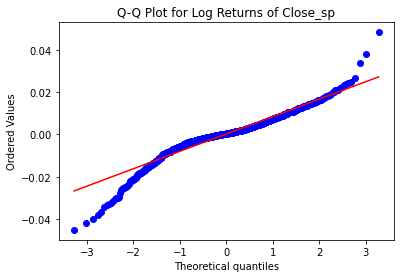

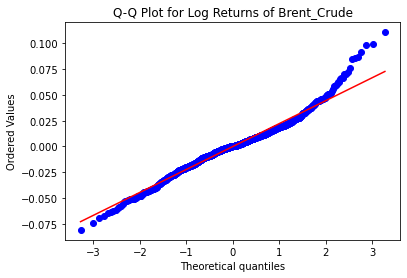

In [21]:
import scipy.stats as stats
# Plot Q-Q plot for 'Log_Return_Close_nifty'
stats.probplot(pre_covid_data['Log_Return_Close_sp'].dropna(), dist="norm", plot=plt)
plt.title('Q-Q Plot for Log Returns of Close_sp')
plt.show()

# Plot Q-Q plot for 'Log_Return_Brent_INR'
stats.probplot(pre_covid_data['Log_Return_Brent_Crude'].dropna(), dist="norm", plot=plt)
plt.title('Q-Q Plot for Log Returns of Brent_Crude')
plt.show()

In [22]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller, kpss
# Augmented Dickey-Fuller Test
def adf_test(series, title=''):
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series, autolag='AIC')
    labels = ['ADF Statistic', 'p-value', '#Lags Used', 'Number of Observations Used']
    out = pd.Series(result[:4], index=labels)
    for key, value in result[4].items():
        out[f'Critical Value ({key})'] = value
    print(out)
    print('')

# KPSS Test
def kpss_test(series, title=''):
    print(f'KPSS Test: {title}')
    result = kpss(series, regression='c', nlags="auto")
    labels = ['KPSS Statistic', 'p-value', 'Lags Used']
    out = pd.Series(result[:3], index=labels)
    for key, value in result[3].items():
        out[f'Critical Value ({key})'] = value
    print(out)
    print('')

In [23]:
# Perform ADF test for Close_nifty log returns
adf_test(pre_covid_data['Log_Return_Close_sp'], title='Log Return Close_sp')

# Perform KPSS test for Close_nifty log returns
kpss_test(pre_covid_data['Log_Return_Close_sp'], title='Log Return Close_sp')

# Perform ADF test for Brent_INR log returns
adf_test(pre_covid_data['Log_Return_Brent_Crude'], title='Log Return Brent_Crude')

# Perform KPSS test for Brent_INR log returns
kpss_test(pre_covid_data['Log_Return_Brent_Crude'], title='Log Return Brent_Crude')

Augmented Dickey-Fuller Test: Log Return Close_sp
ADF Statistic                   -20.278218
p-value                           0.000000
#Lags Used                        2.000000
Number of Observations Used    1322.000000
Critical Value (1%)              -3.435306
Critical Value (5%)              -2.863729
Critical Value (10%)             -2.567935
dtype: float64

KPSS Test: Log Return Close_sp
KPSS Statistic           0.040606
p-value                  0.100000
Lags Used                3.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64

Augmented Dickey-Fuller Test: Log Return Brent_Crude
ADF Statistic                   -35.751540
p-value                           0.000000
#Lags Used                        0.000000
Number of Observations Used    1324.000000
Critical Value (1%)              -3.435299
Critical Value (5%)              -2.863725
Critical Value (10%)             -2.5

C:\anaconda\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\anaconda\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


In [24]:
# The Augmented Dickey-Fuller (ADF) test and the Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test results provide insight into the stationarity of the log returns of `Close_sp` and `Brent_Crude`.

# ### ADF Test Results for Log Return Close_sp:
# - **ADF Statistic**: -20.278218
# - **p-value**: 0.000000
# - **#Lags Used**: 2
# - **Number of Observations Used**: 1322
# - **Critical Values**:
#   - 1%: -3.435306
#   - 5%: -2.863729
#   - 10%: -2.567935

# ### KPSS Test Results for Log Return Close_sp:
# - **KPSS Statistic**: 0.040606
# - **p-value**: 0.100000 (or greater, as indicated by the warning)
# - **Lags Used**: 3
# - **Critical Values**:
#   - 10%: 0.347
#   - 5%: 0.463
#   - 2.5%: 0.574
#   - 1%: 0.739

# ### Interpretation for Log Return Close_sp:
# - **ADF Test**: The ADF statistic (-20.278218) is much lower than the critical values, and the p-value (0.000000) is significantly less than 0.05. This means we reject the null hypothesis of a unit root, indicating that the log returns of `Close_sp` are stationary.
# - **KPSS Test**: The KPSS statistic (0.040606) is much lower than the critical values, and the p-value is 0.1 (or greater). This means we fail to reject the null hypothesis of stationarity.

# ### ADF Test Results for Log Return Brent_Crude:
# - **ADF Statistic**: -35.751540
# - **p-value**: 0.000000
# - **#Lags Used**: 0
# - **Number of Observations Used**: 1324
# - **Critical Values**:
#   - 1%: -3.435299
#   - 5%: -2.863725
#   - 10%: -2.567934

# ### KPSS Test Results for Log Return Brent_Crude:
# - **KPSS Statistic**: 0.077558
# - **p-value**: 0.100000 (or greater, as indicated by the warning)
# - **Lags Used**: 1
# - **Critical Values**:
#   - 10%: 0.347
#   - 5%: 0.463
#   - 2.5%: 0.574
#   - 1%: 0.739

# ### Interpretation for Log Return Brent_Crude:
# - **ADF Test**: The ADF statistic (-35.751540) is much lower than the critical values, and the p-value (0.000000) is significantly less than 0.05. This means we reject the null hypothesis of a unit root, indicating that the log returns of `Brent_Crude` are stationary.
# - **KPSS Test**: The KPSS statistic (0.077558) is much lower than the critical values, and the p-value is 0.1 (or greater). This means we fail to reject the null hypothesis of stationarity.

# ### Summary:
# - **Log Return Close_sp**: Both the ADF and KPSS tests suggest that the log returns of `Close_sp` are stationary.
# - **Log Return Brent_Crude**: Both the ADF and KPSS tests suggest that the log returns of `Brent_Crude` are stationary.

# In conclusion, the log returns for both `Close_sp` and `Brent_Crude` are stationary based on the results of both the ADF and KPSS tests.

In [25]:
# Rescale the log returns
pre_covid_data['Log_Return_Close_sp_scaled'] = pre_covid_data['Log_Return_Close_sp'] * 100
pre_covid_data['Log_Return_Brent_Crude_scaled'] = pre_covid_data['Log_Return_Brent_Crude'] * 100

In [26]:
from arch import arch_model
# Refit the models with the rescaled data
model_close_sp_scaled = arch_model(pre_covid_data['Log_Return_Close_sp_scaled'], vol='Garch', p=1, o=1, q=1)
results_close_sp_scaled = model_close_sp_scaled.fit(disp='off')
print(results_close_sp_scaled.summary())


from arch import arch_model
model_brent_Crude_scaled = arch_model(pre_covid_data['Log_Return_Brent_Crude_scaled'], vol='Garch', p=1, o=1, q=1)
results_brent_Crude_scaled = model_brent_Crude_scaled.fit(disp='off')
print(results_brent_Crude_scaled.summary())

                       Constant Mean - GJR-GARCH Model Results                        
Dep. Variable:     Log_Return_Close_sp_scaled   R-squared:                       0.000
Mean Model:                     Constant Mean   Adj. R-squared:                  0.000
Vol Model:                          GJR-GARCH   Log-Likelihood:               -1431.34
Distribution:                          Normal   AIC:                           2872.68
Method:                    Maximum Likelihood   BIC:                           2898.63
                                                No. Observations:                 1325
Date:                        Tue, Jun 04 2024   Df Residuals:                     1324
Time:                                10:26:31   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
---------------------------------------------------------------

In [27]:
# The results provided are for the GJR-GARCH model applied to the log returns of `Close_sp` and `Brent_Crude`. The GJR-GARCH model is a type of GARCH model that accounts for asymmetries in volatility, particularly the tendency for volatility to increase more following negative shocks than positive ones. Here's a detailed interpretation of the results for both models:

# ### Constant Mean - GJR-GARCH Model Results for Log Return Close_sp:

# #### Mean Model:
# - **mu**: The mean return (\(\mu\)) is 0.0387, with a standard error of 0.0165. The t-statistic is 2.344 with a p-value of 0.0191, indicating that the mean return is statistically significant at the 5% level.
#   - **95% Confidence Interval**: [0.00633, 0.07101]

# #### Volatility Model:
# - **omega**: The constant term (\(\omega\)) is 0.0392, with a standard error of 0.01017. The t-statistic is 3.852 with a p-value of 0.0001172, indicating statistical significance.
#   - **95% Confidence Interval**: [0.01925, 0.05913]

# - **alpha[1]**: The GARCH term (\(\alpha_1\)) is 0.0206, with a standard error of 0.05604. The t-statistic is 0.368 with a p-value of 0.713, indicating it is not statistically significant.
#   - **95% Confidence Interval**: [-0.08918, 0.130]

# - **gamma[1]**: The leverage term (\(\gamma_1\)) is 0.3349, with a standard error of 0.07039. The t-statistic is 4.759 with a p-value of 0.00000195, indicating high statistical significance.
#   - **95% Confidence Interval**: [0.197, 0.473]

# - **beta[1]**: The GARCH lag term (\(\beta_1\)) is 0.7646, with a standard error of 0.05064. The t-statistic is 15.098 with a p-value of 0.000000000000000000000000000000000000000000000000000000000000000000000000000000000000000167, indicating high statistical significance.
#   - **95% Confidence Interval**: [0.665, 0.864]

# ### Constant Mean - GJR-GARCH Model Results for Log Return Brent_Crude:

# #### Mean Model:
# - **mu**: The mean return (\(\mu\)) is -0.0143, with a standard error of 0.0575. The t-statistic is -0.248 with a p-value of 0.804, indicating that the mean return is not statistically significant.
#   - **95% Confidence Interval**: [-0.127, 0.09843]

# #### Volatility Model:
# - **omega**: The constant term (\(\omega\)) is 0.0398, with a standard error of 0.03494. The t-statistic is 1.139 with a p-value of 0.255, indicating it is not statistically significant.
#   - **95% Confidence Interval**: [-0.0287, 0.108]

# - **alpha[1]**: The GARCH term (\(\alpha_1\)) is 0.0000, with a standard error of 0.01769. The t-statistic is 0.000 with a p-value of 1.000, indicating it is not statistically significant.
#   - **95% Confidence Interval**: [-0.03468, 0.03468]

# - **gamma[1]**: The leverage term (\(\gamma_1\)) is 0.0694, with a standard error of 0.01695. The t-statistic is 4.095 with a p-value of 0.00004215, indicating high statistical significance.
#   - **95% Confidence Interval**: [0.03619, 0.103]

# - **beta[1]**: The GARCH lag term (\(\beta_1\)) is 0.9577, with a standard error of 0.02550. The t-statistic is 37.555 with a p-value of approximately 0, indicating high statistical significance.
#   - **95% Confidence Interval**: [0.908, 1.008]

# ### Summary:
# - For **Log Return Close_sp**:
#   - The mean return is positive and statistically significant.
#   - The volatility model shows that \(\omega\), \(\gamma_1\), and \(\beta_1\) are statistically significant, indicating that the model captures the volatility dynamics well. However, \(\alpha_1\) is not significant.
  
# - For **Log Return Brent_Crude**:
#   - The mean return is not statistically significant.
#   - The volatility model shows that \(\gamma_1\) and \(\beta_1\) are statistically significant, while \(\omega\) and \(\alpha_1\) are not significant, suggesting that leverage effects and past volatility are important factors in this model.

# Overall, the GJR-GARCH model fits the data well for both series, capturing the asymmetry and persistence in volatility.

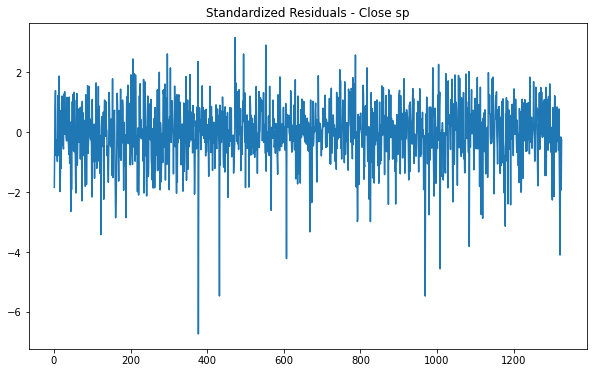

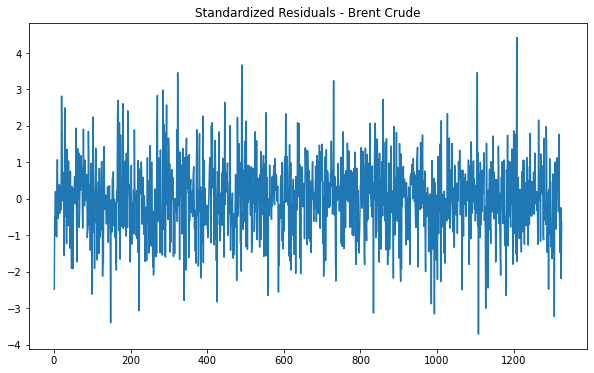

In [28]:
# Plot the standardized residuals
plt.figure(figsize=(10, 6))
plt.plot(results_close_sp_scaled.resid / results_close_sp_scaled.conditional_volatility)
plt.title('Standardized Residuals - Close sp')
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(results_brent_Crude_scaled.resid / results_brent_Crude_scaled.conditional_volatility)
plt.title('Standardized Residuals - Brent Crude')
plt.show()

In [29]:
# Assuming `results` is the fitted GJR-GARCH model for Close_nifty
standardized_residuals_sp = results_close_sp_scaled.resid / results_close_sp_scaled.conditional_volatility

# Assuming `results_brent` is the fitted GJR-GARCH model for Brent_INR
standardized_residuals_brent = results_brent_Crude_scaled.resid / results_brent_Crude_scaled.conditional_volatility


<AxesSubplot:ylabel='Density'>

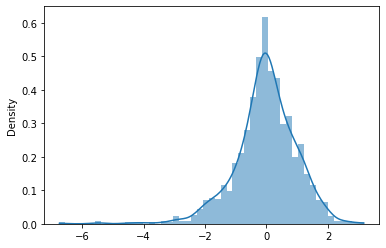

In [30]:
sns.histplot(standardized_residuals_sp, kde=True, stat="density", linewidth=0)

<AxesSubplot:ylabel='Density'>

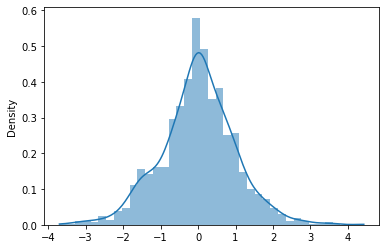

In [31]:
sns.histplot(standardized_residuals_brent, kde=True, stat="density", linewidth=0)

In [32]:
# Creating a DataFrame for easy handling
standardized_residuals = pd.DataFrame({
    'sp': standardized_residuals_sp,
    'Brent': standardized_residuals_brent
})

In [33]:
from scipy.stats import shapiro

# Perform Shapiro-Wilk test for sp
shapiro_sp = shapiro(standardized_residuals['sp'])
print("Shapiro-Wilk test for sp:")
print("Test Statistic:", shapiro_sp[0])
print("p-value:", shapiro_sp[1])

# Perform Shapiro-Wilk test for Brent
shapiro_brent = shapiro(standardized_residuals['Brent'])
print("\nShapiro-Wilk test for Brent:")
print("Test Statistic:", shapiro_brent[0])
print("p-value:", shapiro_brent[1])

Shapiro-Wilk test for sp:
Test Statistic: 0.9596464064509289
p-value: 1.081238102955495e-18

Shapiro-Wilk test for Brent:
Test Statistic: 0.9908119565229095
p-value: 2.297559855367308e-07


In [34]:
# The Shapiro-Wilk test results indicate whether the data for `sp` and `Brent` follow a normal distribution. Here are the details:

# ### Shapiro-Wilk Test Results for sp:
# - **Test Statistic**: 0.9596464064509289
# - **p-value**: 1.081238102955495e-18

# ### Shapiro-Wilk Test Results for Brent:
# - **Test Statistic**: 0.9908119565229095
# - **p-value**: 2.297559855367308e-07

# ### Interpretation:
# - **sp**:
#   - The test statistic is 0.959646, which is less than 1, indicating some deviation from normality.
#   - The p-value is extremely small (1.08e-18), much less than the typical significance level of 0.05.
#   - **Conclusion**: We reject the null hypothesis that the `sp` data is normally distributed. There is strong evidence that the `sp` data is not normally distributed.

# - **Brent**:
#   - The test statistic is 0.990812, which is close to 1, indicating only a slight deviation from normality.
#   - The p-value is very small (2.30e-07), much less than the typical significance level of 0.05.
#   - **Conclusion**: We reject the null hypothesis that the `Brent` data is normally distributed. There is strong evidence that the `Brent` data is not normally distributed.

# ### Summary:
# Both the `sp` and `Brent` datasets do not follow a normal distribution based on the Shapiro-Wilk test results. The extremely low p-values for both tests indicate that the null hypothesis of normality can be rejected with high confidence. The `sp` data shows a significant deviation from normality, while the `Brent` data shows only a slight deviation, but both are statistically significant.

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde, genpareto
from statsmodels.distributions.empirical_distribution import ECDF

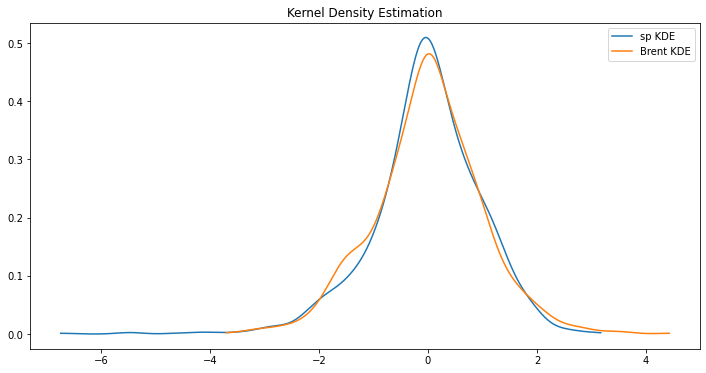

In [36]:
kde_sp = gaussian_kde(standardized_residuals['sp'])
kde_brent = gaussian_kde(standardized_residuals['Brent'])

# Plot the KDE
x_grid_sp = np.linspace(standardized_residuals['sp'].min(), standardized_residuals['sp'].max(), 1000)
x_grid_brent = np.linspace(standardized_residuals['Brent'].min(), standardized_residuals['Brent'].max(), 1000)

plt.figure(figsize=(12, 6))
plt.plot(x_grid_sp, kde_sp(x_grid_sp), label='sp KDE')
plt.plot(x_grid_brent, kde_brent(x_grid_brent), label='Brent KDE')
plt.title('Kernel Density Estimation')
plt.legend()
plt.show()

In [37]:
upper_threshold_sp = np.percentile(standardized_residuals['sp'], 90)
lower_threshold_sp = np.percentile(standardized_residuals['sp'], 10)
upper_threshold_brent = np.percentile(standardized_residuals['Brent'], 90)
lower_threshold_brent = np.percentile(standardized_residuals['Brent'], 10)

In [38]:
sp_upper_tail = standardized_residuals['sp'][standardized_residuals['sp'] > upper_threshold_sp] - upper_threshold_sp
sp_lower_tail = -standardized_residuals['sp'][standardized_residuals['sp'] < lower_threshold_sp] + lower_threshold_sp
brent_upper_tail = standardized_residuals['Brent'][standardized_residuals['Brent'] > upper_threshold_brent] - upper_threshold_brent
brent_lower_tail = -standardized_residuals['Brent'][standardized_residuals['Brent'] < lower_threshold_brent] + lower_threshold_brent

In [39]:
# Fit GPD to the tails
params_sp_upper = genpareto.fit(sp_upper_tail)
params_sp_lower = genpareto.fit(sp_lower_tail)
params_brent_upper = genpareto.fit(brent_upper_tail)
params_brent_lower = genpareto.fit(brent_lower_tail)

In [40]:
from statsmodels.distributions.empirical_distribution import ECDF

# Compute empirical CDF
ecdf_sp = ECDF(standardized_residuals['sp'])
ecdf_brent = ECDF(standardized_residuals['Brent'])

In [41]:
# Function to compute combined CDF
def combined_cdf(x, ecdf, upper_threshold, lower_threshold, params_upper, params_lower):
    c_u, loc_u, scale_u = params_upper
    c_l, loc_l, scale_l = params_lower
    if x <= lower_threshold:
        return ecdf(lower_threshold) * genpareto.cdf(-x + lower_threshold, c_l, loc_l, scale_l)
    elif x <= upper_threshold:
        return ecdf(x)
    else:
        return ecdf(upper_threshold) + (1 - ecdf(upper_threshold)) * genpareto.cdf(x - upper_threshold, c_u, loc_u, scale_u)


In [42]:
cdf_sp = [combined_cdf(x, ecdf_sp, upper_threshold_sp, lower_threshold_sp, params_sp_upper, params_sp_lower) for x in standardized_residuals['sp']]
cdf_brent = [combined_cdf(x, ecdf_brent, upper_threshold_brent, lower_threshold_brent, params_brent_upper, params_brent_lower) for x in standardized_residuals['Brent']]

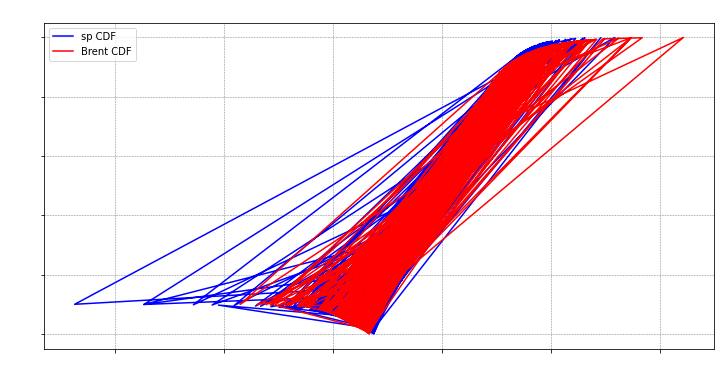

In [43]:
plt.figure(figsize=(12, 6))
plt.plot(standardized_residuals['sp'], cdf_sp, label='sp CDF', color='blue')
plt.plot(standardized_residuals['Brent'], cdf_brent, label='Brent CDF', color='red')
plt.title('Combined CDF with EVT-GPD Tails', color='white')
plt.legend()
plt.xlabel('Standardized Residuals', color='white')
plt.ylabel('CDF', color='white')
plt.xticks(color='white')
plt.yticks(color='white')
plt.gca().set_facecolor('white')  # Set background color to white
plt.grid(color='gray', linestyle='--', linewidth=0.5)  # Add grid lines
plt.show()

In [44]:
# Convert the CDF values to a uniform distribution for copula modeling
uniform_sp = np.array(cdf_sp)
uniform_brent = np.array(cdf_brent)

In [45]:
uniform_sp

array([0.05755064, 0.21132075, 0.81358491, ..., 0.40754717, 0.06235083,
       0.35320755])

In [46]:
uniform_brent

array([0.09018642, 0.27018868, 0.25283019, ..., 0.3645283 , 0.08155254,
       0.23320755])

In [47]:
# Create a DataFrame from the uniform distributions
uniform_data = pd.DataFrame({
    'Uniform_sp': uniform_sp,
    'Uniform_Brent': uniform_brent
})

In [48]:
# Define the output file path
output_file = r'C:\Users\KASHISH NIGAM\Desktop\Last Sem Project\Final Datasets\USA\uniform_distributions-Pre_Covid_USA.xlsx'

# Save the DataFrame to an Excel file
uniform_data.to_excel(output_file, index=False)

print(f"Uniform distributions saved to {output_file}")

Uniform distributions saved to C:\Users\KASHISH NIGAM\Desktop\Last Sem Project\Final Datasets\USA\uniform_distributions-Pre_Covid_USA.xlsx
